## RQ1

Index(['Testbed', 'Algorithm', 'Bug No.', 'Bug File', 'Bug category',
       'Real life bug?', 'Fuzzy Oracle Pass Rate', 'Human Oracle Pass Rate'],
      dtype='object')


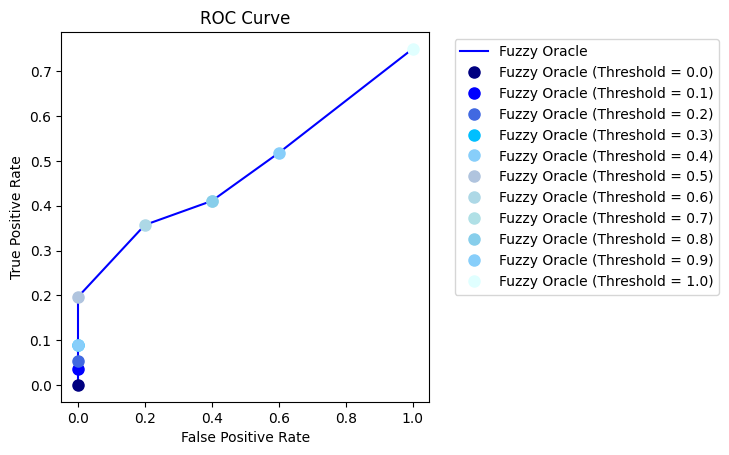

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt


# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred, threshold):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    return [threshold, tpr, fpr, accuracy, precision, f1]

# 定义绘制ROC曲线的函数
def plot_roc_curve(fpr, tpr, thresholds, label, color, point_colors):
    plt.plot(fpr, tpr, label=label, color=color)
    
    # 选择要标注的阈值
    selected_thresholds = np.arange(0, 1.1, 0.1)
    
    for i, threshold in enumerate(selected_thresholds):
        idx = np.argmin(np.abs(thresholds - threshold))
        plt.plot(fpr[idx], tpr[idx], 'o', markersize=8, label=f'{label} (Threshold = {threshold:.1f})', color=point_colors[i])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


# 读取CSV文件
data = pd.read_csv('Oracle Result 2.csv', skiprows=1, header=0)

# 定义阈值范围
thresholds = np.arange(0, 1.1, 0.1)

# 初始化结果数组
fuzzy_results = []

print(data.columns)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 对每个阈值进行分析
for threshold in thresholds:
    # 根据阈值计算Fuzzy Oracle的判定结果
    data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= threshold else 'Positive')
    
    # 计算评估指标
    fuzzy_metrics = calculate_metrics(data['True_Label'], data['Fuzzy_Prediction'], threshold)
    
    # 存储结果
    fuzzy_results.append(fuzzy_metrics)


# 将结果转换为DataFrame
fuzzy_df = pd.DataFrame(fuzzy_results, columns=['Threshold', 'TPR', 'FPR', 'Accuracy', 'Precision', 'F1'])

# 定义阈值点的颜色
fuzzy_point_colors = ['navy', 'blue', 'royalblue', 'deepskyblue', 'lightskyblue', 'lightsteelblue', 'lightblue', 'powderblue', 'skyblue', 'lightskyblue', 'lightcyan', 'paleturquoise']

# 绘制ROC曲线
plot_roc_curve(fuzzy_df['FPR'], fuzzy_df['TPR'], fuzzy_df['Threshold'], 'Fuzzy Oracle', 'blue', fuzzy_point_colors)

plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.7)
plt.show()


# 计算AUC值
fuzzy_auc = auc(fuzzy_df['FPR'], fuzzy_df['TPR'])

# print(f"Fuzzy Oracle AUC: {fuzzy_auc:.2f}")

## RQ2

In [17]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result 2.csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 计算混淆矩阵
confusion_matrix = pd.crosstab(data['True_Label'], data['Fuzzy_Prediction'], rownames=['True Label'], colnames=['Fuzzy Prediction'])

# 计算性能指标
true_positive = confusion_matrix.loc['Positive', 'Problem']
false_positive = confusion_matrix.loc['Negative', 'Problem']
true_negative = confusion_matrix.loc['Negative', 'No Problem']
false_negative = confusion_matrix.loc['Positive', 'No Problem']

# 按环境和算法分组计算性能指标
performance_by_group = data.groupby(['Testbed', 'Algorithm']).apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Positive': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'True Negative': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'No Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
}))

# 打印结果
print("Confusion Matrix:")
print(confusion_matrix)
print("\nPerformance by Environment and Algorithm:")
print(performance_by_group)

Confusion Matrix:
Fuzzy Prediction  No Problem  Problem
True Label                           
Negative                   4        1
Positive                  36       20

Performance by Environment and Algorithm:
                                   True Positive  False Positive  \
Testbed                 Algorithm                                  
Frozen Lake             A2C                    1               0   
                        DQN                    8               1   
                        PPO                    1               0   
Mountaincar Continuous  A2C                    8               0   
                        PPO                    2               0   

                                   True Negative  False Negative  
Testbed                 Algorithm                                 
Frozen Lake             A2C                    1               8  
                        DQN                    0               7  
                        PPO               

/var/folders/37/mwcx5pmx1k7c6s8w_rj88r080000gq/T/ipykernel_66995/212519255.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_group = data.groupby(['Testbed', 'Algorithm']).apply(lambda x: pd.Series({


## RQ3

In [25]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result 2.csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 过滤掉没有bug的样本
data_with_bugs = data[data['True_Label'] == 'Positive']

# 按Bug类型分组计算性能指标
performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
})).fillna(0).astype(int)

# 计算每个Bug类型的Recall
performance_by_bug_type['Recall'] = performance_by_bug_type['True Positive'] / (performance_by_bug_type['True Positive'] + performance_by_bug_type['False Negative'])

# 打印每个Bug类型的Recall
# Recall = 正确识别出的有bug的RL程序数 / 实际有bug的RL程序总数
print("Recall by Bug Category:")
for bug_type in performance_by_bug_type.index:
    recall = performance_by_bug_type.loc[bug_type, 'Recall']
    print(f"Bug Category: {bug_type}")
    print(f"Recall: {recall:.2f}")
    print()

Recall by Bug Category:
Bug Category: Exploring the enviroment
Recall: 0.50

Bug Category: Model
Recall: 0.33

Bug Category: Training
Recall: 0.30

Bug Category: Training Loss function
Recall: 0.46

Bug Category: Training Optimizer
Recall: 0.29

Bug Category: Updating network
Recall: 0.38



/var/folders/37/mwcx5pmx1k7c6s8w_rj88r080000gq/T/ipykernel_66995/2856876470.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({


## RQ4

In [13]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result 4.csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return [accuracy, precision, recall, f1]

# 获取不同的Environment
environments = data['Testbed'].unique()

# 在不同的Environment中计算两种方法的优劣性
for env in environments:
    env_data = data[data['Testbed'] == env]
    
    # 计算Fuzzy Oracle的评估指标
    fuzzy_metrics = calculate_metrics(env_data['True_Label'], env_data['Fuzzy_Prediction'])
    print(f"Environment: {env}")
    print("Fuzzy Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*fuzzy_metrics))
    
    # 计算Human Oracle的评估指标
    human_metrics = calculate_metrics(env_data['True_Label'], env_data['Human_Prediction'])
    print("Human Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*human_metrics))
    
    # 比较两种Oracle的F1 Score
    if fuzzy_metrics[3] > human_metrics[3]:
        print("Fuzzy Oracle的性能更优\n")
    elif fuzzy_metrics[3] < human_metrics[3]:
        print("Human Oracle的性能更优\n")
    else:
        print("两种Oracle的性能相当\n")

Environment: Frozen Lake
Fuzzy Oracle:
Accuracy: 0.31, Precision: 0.91, Recall: 0.28, F1 Score: 0.43
Human Oracle:
Accuracy: 0.67, Precision: 0.96, Recall: 0.67, F1 Score: 0.79
Human Oracle的性能更优

Environment: Mountaincar Continuous 
Fuzzy Oracle:
Accuracy: 0.55, Precision: 1.00, Recall: 0.50, F1 Score: 0.67
Human Oracle:
Accuracy: 0.59, Precision: 1.00, Recall: 0.55, F1 Score: 0.71
Human Oracle的性能更优



In [26]:
import pandas as pd
import numpy as np

# 读取CSV文件
data = pd.read_csv('Oracle Result 2_new.csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
    
    return [accuracy, precision, recall, f1, mcc]

# 获取不同的Bug Category
bug_categories = data['Bug category'].unique()

# 在不同的Bug Category中计算两种方法的优劣性
for category in bug_categories:
    category_data = data[data['Bug category'] == category]
    
    if len(category_data) == 0:
        continue
    
    # 计算Fuzzy Oracle在该Bug Category上的评估指标
    fuzzy_metrics = calculate_metrics(category_data['True_Label'], category_data['Fuzzy_Prediction'])
    print(f"Bug category: {category}")
    print("Fuzzy Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, MCC:{:.2f}".format(*fuzzy_metrics))
    
    # 计算Human Oracle在该Bug Category上的评估指标
    human_metrics = calculate_metrics(category_data['True_Label'], category_data['Human_Prediction'])
    print("Human Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, MCC:{:.2f}".format(*human_metrics))
    
    print("---")

Bug category: Updating network
Fuzzy Oracle:
Accuracy: 0.38, Precision: 1.00, Recall: 0.38, F1: 0.55, MCC:0.00
Human Oracle:
Accuracy: 0.50, Precision: 1.00, Recall: 0.50, F1: 0.67, MCC:0.00
---
Bug category: Training
Fuzzy Oracle:
Accuracy: 0.30, Precision: 1.00, Recall: 0.30, F1: 0.46, MCC:0.00
Human Oracle:
Accuracy: 0.80, Precision: 1.00, Recall: 0.80, F1: 0.89, MCC:0.00
---
Bug category: Model
Fuzzy Oracle:
Accuracy: 0.33, Precision: 1.00, Recall: 0.33, F1: 0.50, MCC:0.00
Human Oracle:
Accuracy: 0.50, Precision: 1.00, Recall: 0.50, F1: 0.67, MCC:0.00
---
Bug category: Training Loss function
Fuzzy Oracle:
Accuracy: 0.46, Precision: 1.00, Recall: 0.46, F1: 0.63, MCC:0.00
Human Oracle:
Accuracy: 0.46, Precision: 1.00, Recall: 0.46, F1: 0.63, MCC:0.00
---
Bug category: Training Optimizer
Fuzzy Oracle:
Accuracy: 0.29, Precision: 1.00, Recall: 0.29, F1: 0.44, MCC:0.00
Human Oracle:
Accuracy: 0.43, Precision: 1.00, Recall: 0.43, F1: 0.60, MCC:0.00
---
Bug category: Exploring the envirome

In [28]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result 2_new.csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
import numpy as np

def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
    
    return [accuracy, precision, recall, f1, mcc]

# 获取不同的Environment和Algorithm
environments = data['Testbed'].unique()
algorithms = data['Algorithm'].unique()

# 在不同的Environment和Algorithm组合中计算两种方法的优劣性
for env in environments:
    for algo in algorithms:
        env_algo_data = data[(data['Testbed'] == env) & (data['Algorithm'] == algo)]
        
        if len(env_algo_data) == 0:
            continue
        
        # 计算Fuzzy Oracle的评估指标
        fuzzy_metrics = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Fuzzy_Prediction'])
        print(f"Environment: {env}, Algorithm: {algo}")
        print("Fuzzy Oracle:")
        # print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}".format(*fuzzy_metrics))
        print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, MCC:{:.2f}".format(*fuzzy_metrics))
        
        # 计算Human Oracle的评估指标
        human_metrics = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Human_Prediction'])
        print("Human Oracle:")
        # print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}".format(*human_metrics))
        print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, MCC:{:.2f}".format(*human_metrics))
        print('----')
        


Environment: Frozen Lake, Algorithm: A2C
Fuzzy Oracle:
Accuracy: 0.20, Precision: 1.00, Recall: 0.11, F1: 0.20, MCC:0.11
Human Oracle:
Accuracy: 0.50, Precision: 1.00, Recall: 0.44, F1: 0.62, MCC:0.27
----
Environment: Frozen Lake, Algorithm: DQN
Fuzzy Oracle:
Accuracy: 0.50, Precision: 0.89, Recall: 0.53, F1: 0.67, MCC:-0.23
Human Oracle:
Accuracy: 0.81, Precision: 0.93, Recall: 0.87, F1: 0.90, MCC:-0.10
----
Environment: Frozen Lake, Algorithm: PPO
Fuzzy Oracle:
Accuracy: 0.15, Precision: 1.00, Recall: 0.08, F1: 0.15, MCC:0.08
Human Oracle:
Accuracy: 0.54, Precision: 1.00, Recall: 0.50, F1: 0.67, MCC:0.27
----
Environment: Mountaincar Continuous , Algorithm: A2C
Fuzzy Oracle:
Accuracy: 0.90, Precision: 1.00, Recall: 0.89, F1: 0.94, MCC:0.67
Human Oracle:
Accuracy: 0.80, Precision: 1.00, Recall: 0.78, F1: 0.88, MCC:0.51
----
Environment: Mountaincar Continuous , Algorithm: PPO
Fuzzy Oracle:
Accuracy: 0.25, Precision: 1.00, Recall: 0.18, F1: 0.31, MCC:0.13
Human Oracle:
Accuracy: 0.42,

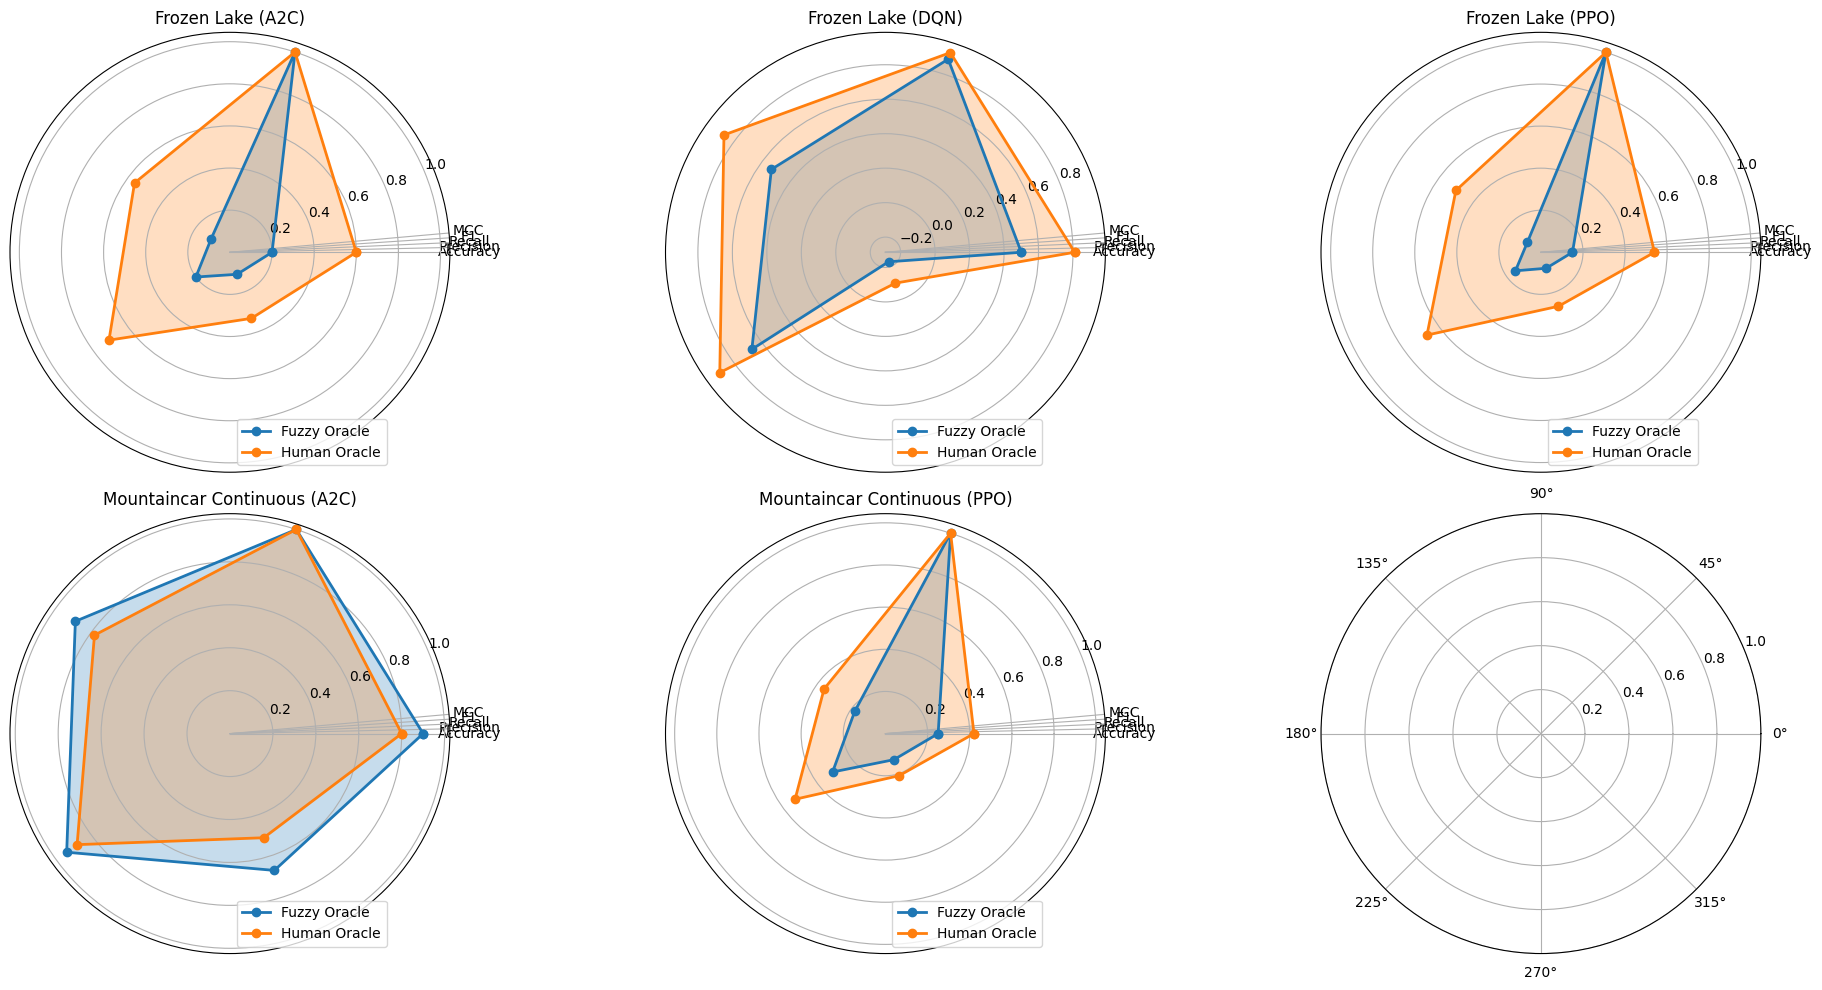

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 定义数据
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC']
envs_algos = ['Frozen Lake (A2C)', 'Frozen Lake (DQN)', 'Frozen Lake (PPO)', 'Mountaincar Continuous (A2C)', 'Mountaincar Continuous (PPO)']

fuzzy_data = [
    [0.20, 1.00, 0.11, 0.20, 0.11],
    [0.50, 0.89, 0.53, 0.67, -0.23],
    [0.15, 1.00, 0.08, 0.15, 0.08],
    [0.90, 1.00, 0.89, 0.94, 0.67],
    [0.25, 1.00, 0.18, 0.31, 0.13]
]

human_data = [
    [0.60, 1.00, 0.56, 0.71, 0.33],
    [0.81, 0.93, 0.87, 0.90, -0.10],
    [0.54, 1.00, 0.50, 0.67, 0.27],
    [0.80, 1.00, 0.78, 0.88, 0.51],
    [0.42, 1.00, 0.36, 0.53, 0.21]
]

# 创建雷达图
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for i, (env_algo, fuzzy, human) in enumerate(zip(envs_algos, fuzzy_data, human_data)):
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    fuzzy = np.concatenate((fuzzy, [fuzzy[0]]))
    human = np.concatenate((human, [human[0]]))
    
    axs[i].plot(angles, fuzzy, 'o-', linewidth=2, label='Fuzzy Oracle')
    axs[i].fill(angles, fuzzy, alpha=0.25)
    axs[i].plot(angles, human, 'o-', linewidth=2, label='Human Oracle')
    axs[i].fill(angles, human, alpha=0.25)
    axs[i].set_thetagrids(angles[:-1], labels=metrics)
    axs[i].set_title(env_algo)
    axs[i].grid(True)
    axs[i].legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.tight_layout()
plt.show()